In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

In [12]:
df = pd.read_fwf("interexp.dat")
df.head()

,yA,yB
0,25.33,26.45
1,26.77,27.53
2,22.76,20.02
3,20.94,22.83
4,25.40,28.05


In [22]:
def impute_B(B_mean, yA, A_mean, B_var, A_var, rho):
    return B_mean + (yA - A_mean) * np.sqrt(B_var/A_var) * rho

def impute_A(A_mean, yB, B_mean, A_var, B_var, rho):
    return A_mean + (yB - B_mean) * np.sqrt(A_var/B_var) * rho

In [28]:
θA, θB = df.yA.mean(), df.yB.mean()
σ2A, σ2B = df.yA.var(), df.yB.var()
ρ = df.corr().iloc[0,1]

imputed_df = []
for _, (yA, yB) in df.iterrows():
    if np.isnan(yA):
        imputed_df.append((impute_A(θA, yB, θB, σ2A, σ2B, ρ), yB))
    elif np.isnan(yB):
        imputed_df.append((yA, impute_B(θB, yA, θA, σ2B, σ2A, ρ)))
    else:
        imputed_df.append((yA, yB))

imputed_df = pd.DataFrame(imputed_df, columns=df.columns)

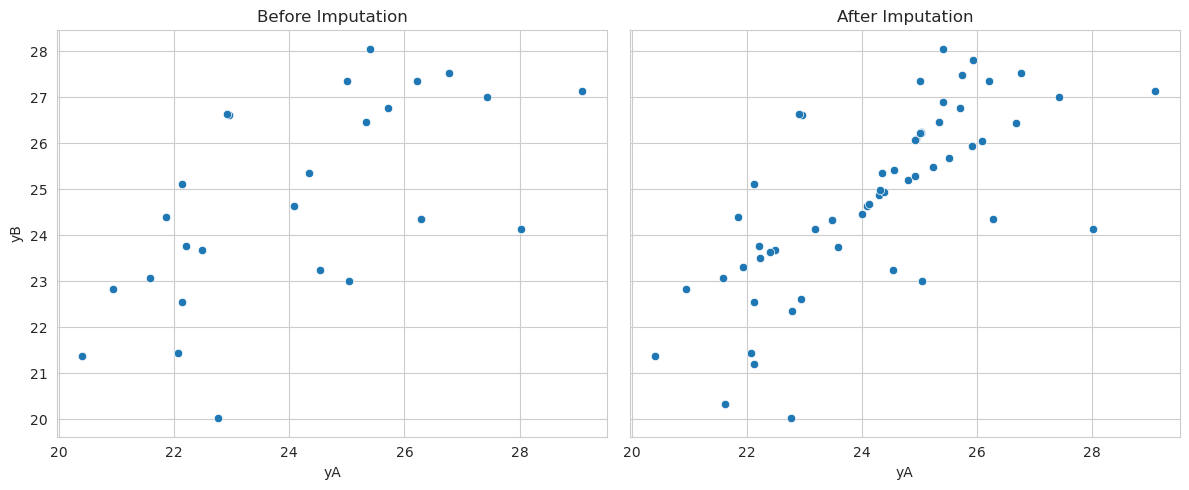

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.scatterplot(data=df, x='yA', y='yB', ax=ax[0])
sns.scatterplot(data=imputed_df, x='yA', y='yB', ax=ax[1])

ax[0].set_title("Before Imputation")
ax[1].set_title("After Imputation")

fig.tight_layout()
fig.show()